In [32]:
from model.utils import save_model
save_model(model)

In [1]:
from model.utils import load_model
model = load_model()

ValueError: File not found: filepath=lstm_multi_output_model4.keras. Please ensure the file is an accessible `.keras` zip file.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Conv1D, Flatten
# 加载数据
# , parse_dates=['日期'], index_col='日期'
data = pd.read_csv('dataeng.csv')
columns = 'Date,Max Temperature,Min Temperature,AQI Index,PM2.5,PM10,SO2,NO2,CO,O3'.split(",")# list(data.columns)# ['日期', '最高气温', '最低气温', 'AQI指数', 'PM2.5', 'PM10', 'So2', 'No2', 'Co', 'O3']
data = data[columns]
values = data.values

sequence_length = 30 + 2  # 时间窗口长度

# 划分训练集和测试集（假设最后30天为测试集）
train_data = values[:-(2 * sequence_length)]  # 训练集：除最后30天外的数据
test_data = values[-(2 * sequence_length):]  # 测试集：最后30天的数据

# 归一化
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)


# 创建时间序列数据
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - (2 * sequence_length)):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length: i + (sequence_length * 2) - 2]) # 卷积核
    return np.array(X), np.array(y)


X_train, y_train = create_sequences(train_scaled, sequence_length)

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Conv1D, Dropout, LayerNormalization, TimeDistributed, Dense, MultiHeadAttention

# 输入层
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

# 添加BiLSTM层
x = Bidirectional(LSTM(units=64, return_sequences=True))(inputs)

# 添加一维卷积层
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)

# 添加MultiHeadAttention层
# x = MultiHeadAttention(num_heads=8, key_dim=64)(query=x, value=x, key=x)  # query, key, value 都是同一个输入

# 添加Dropout层
x = Dropout(0.2)(x)

# 添加LayerNormalization层
x = LayerNormalization()(x)

# 添加TimeDistributed Dense层
outputs = TimeDistributed(Dense(units=y_train.shape[2]))(x)

# 构建模型
model = Model(inputs=inputs, outputs=outputs)

# 编译模型
model.compile(optimizer='adam', loss='mse')

# 打印模型结构
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 32, 128)        │        38,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 30, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 30, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 30, 10)         │           650 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,818 (249.29 KB)

 Trainable params: 63,818 (249.29 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:

# 训练模型
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=512,
    validation_split=0.1
)



Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0079 - val_loss: 0.0049
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0074 - val_loss: 0.0056
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0074 - val_loss: 0.0051
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0074 - val_loss: 0.0050
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0073 - val_loss: 0.0052
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0074 - val_loss: 0.0053
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0074 - val_loss: 0.0053
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0073 - val_loss: 0.0049
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0073 - val_loss: 0.0051
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0072 - val_loss: 0.0051
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0072 - val_loss: 0.0051
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0072 - val_lo

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


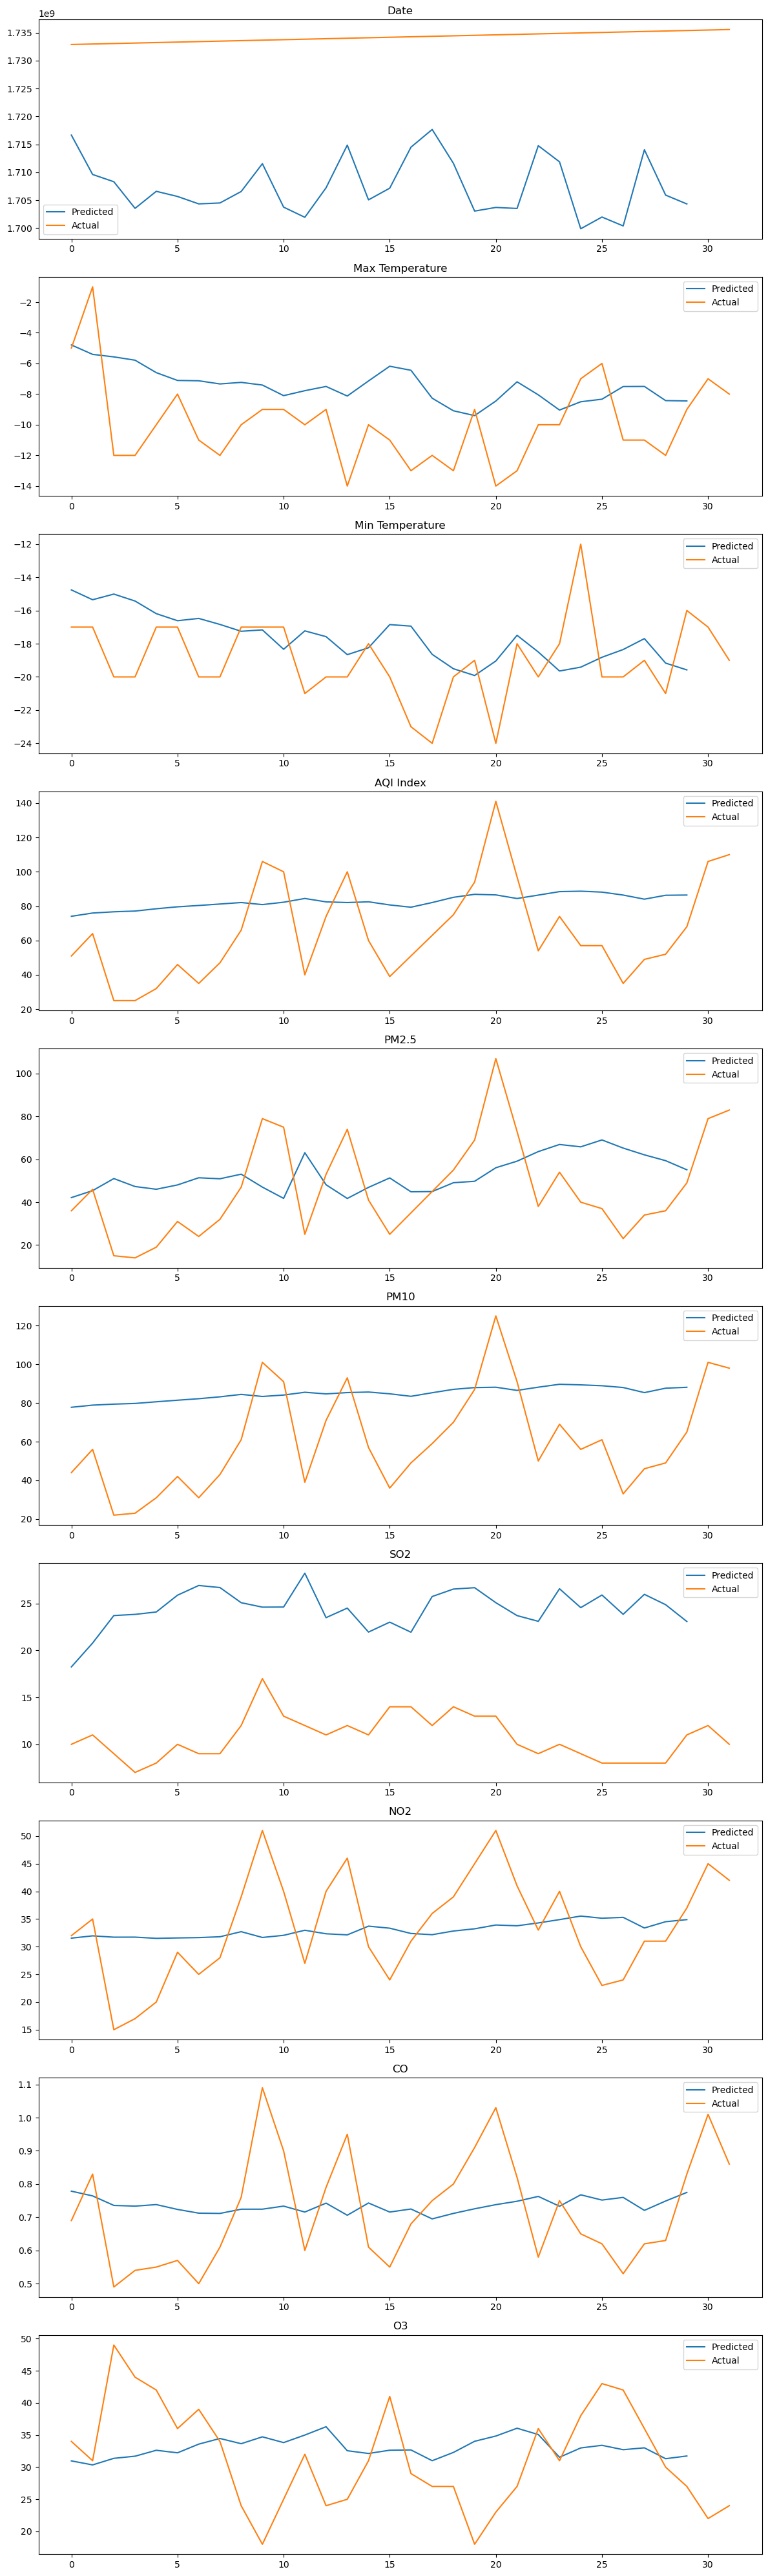

In [20]:
# 假设你已经加载了数据并进行了预处理
# 这里直接使用之前定义的 scaler 和 test_data

# 准备输入数据
# 使用测试集的前 sequence_length 个时间步作为初始输入
input_data = test_data[:sequence_length]
input_data = scaler.transform(input_data)  # 归一化
input_data = input_data.reshape(1, sequence_length, -1)  # 调整形状为 [1, sequence_length, features]

# 进行多步预测
predictions = model.predict(input_data)

# 逆归一化预测结果
predictions = scaler.inverse_transform(predictions[0])

# 可视化结果
# 可视化结果（每个指标一张子图）
plt.rcParams["figure.figsize"] = (12, 4 * len(columns))
fig, axes = plt.subplots(len(columns), 1, figsize=(12, 4 * len(columns)))

for i, col in enumerate(columns):
    ax = axes[i]
    ax.plot(predictions[:, i], label='Predicted')
    ax.plot(test_data[sequence_length:, i], label='Actual')
    ax.set_title(col)
    ax.legend()

plt.tight_layout()
plt.savefig("result3.png")
plt.show()

In [37]:

pd.DataFrame(predictions, columns=data.columns).to_csv("pred30.csv")
pd.DataFrame(test_data[sequence_length: 2 * sequence_length - 2], columns=data.columns).to_csv("true30.csv")
